<a href="https://colab.research.google.com/github/huetech/TFG/blob/main/TFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package installation

All the necesary packages required for the data extraction, manipulation and training with and without Data Augmentation. This section is prepared to be executed within a Google Colab notebook.

In [1]:
%pip install tensorflow keras matplotlib gdown

# Library Imports

In [2]:
import tensorflow as tf
from google.colab import drive
import os

# Making sure the GPU is active
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('No GPU found. Make sure is correctly configured.')
print('A GPU was found in: {}'.format(device_name))


A GPU was found in: /device:GPU:0


# Dataset Download

In order to make this notebook more portable, This code snippet allows you to download and decompress the dataset containing the images directly from the source.

The dataset being used is the **CUB-200-2011**. As specified in the description: "CUB-200-2011 is an extended version of CUB-200, a challenging dataset of 200 bird species. The extended version roughly doubles the number of images per category and adds new part localization annotations" for more information check the [official site](https://authors.library.caltech.edu/records/cvm3y-5hh21).

In [3]:
# Mount google drive
drive.mount('/content/drive')

# Download the folder containing the dataset
folder_id = '1kFzIqZL_pEBVR7Ca_8IKibfWoeZc3GT1'
!gdown --folder https://drive.google.com/drive/folders/{folder_id}

# Verify the download
dataset_dir = '/content/cub-200-2011'
print(os.listdir(dataset_dir))

# Extract the images for the .tgz
!tar -xvzf /content/cub-200-2011/CUB_200_2011.tgz -C /content/cub-200-2011/

Se han truncado las últimas 5000 líneas del flujo de salida.
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0050_111087.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0079_113288.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0004_111989.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0068_113247.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0127_111935.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0094_112773.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0028_113217.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0126_110959.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0007_111029.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0096_111519.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0120_113001.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0010_112678.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0025_111669.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_008

# Dataset & Model Configuration

In [4]:
# General Configuration
image_size = (224, 224)
batch_size = 32
data_dir = '/content/cub-200-2011/CUB_200_2011/images'

### Dataset without Data Augmentation

Configuring the training and testing datasets without data augmentation. 20% of the dataset will be used for validation and no extra images appart from the ones included in the cub-200-2011 dataset will be included in the model training process.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generator applying data augmentation for training and standardization for validation
train_datagen_basic = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training dataset generator
train_generator_basic = train_datagen_basic.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_datagen_basic = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Validation dataset generator
validation_generator_basic = validation_datagen_basic.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 9465 images belonging to 200 classes.
Found 2323 images belonging to 200 classes.


### Augmented Dataset

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generator applying data augmentation for training and standardization for validation
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, # Degree range defined to randomly rotate the images
    width_shift_range=0.15, # Horizontal displacement of the images
    height_shift_range=0.15, # Vertical displacement of the images
    shear_range=0.15, # Image inclination
    zoom_range=0.15, # Random zoom
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of the dataset is used for validation
)

# Training dataset generator
train_generator_augmented = train_datagen_augmented.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_datagen_augmented = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Validation dataset generator
validation_generator_augmented = validation_datagen_augmented.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 9465 images belonging to 200 classes.
Found 2323 images belonging to 200 classes.


## Models

A pre-trained model will be used. ResNet50 and VGG16 are some of the most popular models for image classification. The objective of this method is to transfer all the "knowledge" and applying it to the task of classifying the bird images.

### ResNet50

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Using the ResNet50 model
resNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the layers in the base model
for layer in resNet50_model.layers[-10:]:
    layer.trainable = False

# Adding custom layers for the classifying task
x = resNet50_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
restNet50_predictions = Dense(train_generator_basic.num_classes, activation='softmax')(x)

resNet50_model = Model(inputs=resNet50_model.input, outputs=restNet50_predictions)

# Model compilation
resNet50_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
resNet50_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,890,888 (98.77 MB)

 Trainable params: 21,372,104 (81.53 MB)

 Non-trainable params: 4,518,784 (17.24 MB)

### VGG16

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Cargamos el modelo VGG16 preentrenado
VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelamos las capas del modelo base para no entrenarlas inicialmente
for layer in VGG16_model.layers[-15:]:
    layer.trainable = False

for layer in VGG16_model.layers[:5]:
    layer.trainable = True

# Añadimos capas personalizadas para nuestra tarea de clasificación
x = VGG16_model.output
x = GlobalAveragePooling2D()(x)  # Puedes usar Flatten() en lugar de GlobalAveragePooling2D() si prefieres aplanar la salida
x = Dense(256, activation='relu')(x)  # Capa densa adicional para aprender características más complejas
VGG16_predictions = Dense(train_generator_basic.num_classes, activation='softmax')(x)

VGG16_model = Model(inputs=VGG16_model.input, outputs=VGG16_predictions)

# Compilamos el modelo
VGG16_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
VGG16_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 14,897,416 (56.83 MB)

 Trainable params: 295,304 (1.13 MB)

 Non-trainable params: 14,602,112 (55.70 MB)

# Training

Proceeding to train the model with the previous data generators declared previously

## ResNet50

### ResNet50 Without Data Augmentation

In [9]:
history_ResNet50_basic = resNet50_model.fit(
    train_generator_basic,
    epochs=50,
    validation_data=validation_generator_basic,
    steps_per_epoch=train_generator_basic.samples // batch_size,
    validation_steps=validation_generator_basic.samples // batch_size
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


295/295 ━━━━━━━━━━━━━━━━━━━━ 185s 427ms/step - accuracy: 0.0072 - loss: 5.4551 - val_accuracy: 0.0048 - val_loss: 5.4958
Epoch 2/50
  1/295 ━━━━━━━━━━━━━━━━━━━━ 1:19 269ms/step - accuracy: 0.0312 - loss: 5.0924

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0312 - loss: 5.0924 - val_accuracy: 0.0000e+00 - val_loss: 5.5991
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 93s 313ms/step - accuracy: 0.0763 - loss: 4.8057 - val_accuracy: 0.0204 - val_loss: 5.2940
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - accuracy: 0.1875 - loss: 3.8249 - val_accuracy: 0.0526 - val_loss: 5.3078
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 92s 308ms/step - accuracy: 0.2731 - loss: 3.5436 - val_accuracy: 0.1419 - val_loss: 3.9144
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - accuracy: 0.3750 - loss: 2.8997 - val_accuracy: 0.4211 - val_loss: 2.7077
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 93s 312ms/step - accuracy: 0.5337 - loss: 2.0633 - val_accuracy: 0.4049 - val_loss: 2.3688
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - accuracy: 0.5312 - loss: 1.9669 - val_accuracy: 0.4211 - val_loss: 2.6400
Epoch 9/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 141s 309ms/step - accuracy: 0.7245 - loss: 1.2368 - val

### ResNet50 With Augmented Dataset

In [10]:
history_ResNet50_augmented = resNet50_model.fit(
    train_generator_augmented,
    epochs=50,
    validation_data=validation_generator_augmented,
    steps_per_epoch=train_generator_augmented.samples // batch_size,
    validation_steps=validation_generator_augmented.samples // batch_size
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


295/295 ━━━━━━━━━━━━━━━━━━━━ 166s 555ms/step - accuracy: 0.6969 - loss: 1.1156 - val_accuracy: 0.5859 - val_loss: 1.6378
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 1.0000 - loss: 0.2058 - val_accuracy: 0.4211 - val_loss: 2.3765
Epoch 3/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


295/295 ━━━━━━━━━━━━━━━━━━━━ 200s 545ms/step - accuracy: 0.8154 - loss: 0.6212 - val_accuracy: 0.6007 - val_loss: 1.6143
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - accuracy: 0.9375 - loss: 0.4949 - val_accuracy: 0.6842 - val_loss: 2.1503
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 166s 553ms/step - accuracy: 0.8703 - loss: 0.4777 - val_accuracy: 0.6063 - val_loss: 1.6018
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - accuracy: 0.8750 - loss: 0.3537 - val_accuracy: 0.6842 - val_loss: 1.6323
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 165s 551ms/step - accuracy: 0.8890 - loss: 0.3921 - val_accuracy: 0.6168 - val_loss: 1.6105
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - accuracy: 0.9062 - loss: 0.2640 - val_accuracy: 0.6316 - val_loss: 1.4821
Epoch 9/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 163s 543ms/step - accuracy: 0.9002 - loss: 0.3500 - val_accuracy: 0.6237 - val_loss: 1.5979
Epoch 10/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - accuracy: 0.9375 - loss: 0.3374 - va

## VGG16

### VGG116 Without Data Augmentation

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_VGG16_basic = VGG16_model.fit(
    train_generator_basic,
    epochs=100,
    validation_data=validation_generator_basic,
    steps_per_epoch=train_generator_basic.samples // batch_size,
    validation_steps=validation_generator_basic.samples // batch_size,
    callbacks=[early_stopping]
)


Epoch 1/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 136s 447ms/step - accuracy: 0.0054 - loss: 5.3817 - val_accuracy: 0.0052 - val_loss: 5.3487
Epoch 2/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0000e+00 - loss: 5.2414 - val_accuracy: 0.0000e+00 - val_loss: 5.2815
Epoch 3/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 129s 434ms/step - accuracy: 0.0062 - loss: 5.3398 - val_accuracy: 0.0056 - val_loss: 5.3275
Epoch 4/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 523us/step - accuracy: 0.0000e+00 - loss: 5.4241 - val_accuracy: 0.0000e+00 - val_loss: 5.2363
Epoch 5/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 129s 434ms/step - accuracy: 0.0050 - loss: 5.3259 - val_accuracy: 0.0069 - val_loss: 5.3122
Epoch 6/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.0000e+00 - loss: 5.3034 - val_accuracy: 0.0000e+00 - val_loss: 5.3429
Epoch 7/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 129s 434ms/step - accuracy: 0.0071 - loss: 5.3078 - val_accuracy: 0.0065 - val_loss: 5.3003
Epoch 8/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/ste

### VGG16 With Augmented Dataset

In [ ]:
history_VGG16_augmented = VGG16_model.fit(
    train_generator_augmented,
    epochs=50,
    validation_data=validation_generator_augmented,
    steps_per_epoch=train_generator_augmented.samples // batch_size,
    validation_steps=validation_generator_augmented.samples // batch_size
)

# Results Evaluation & Visualization Without Data Augmentation

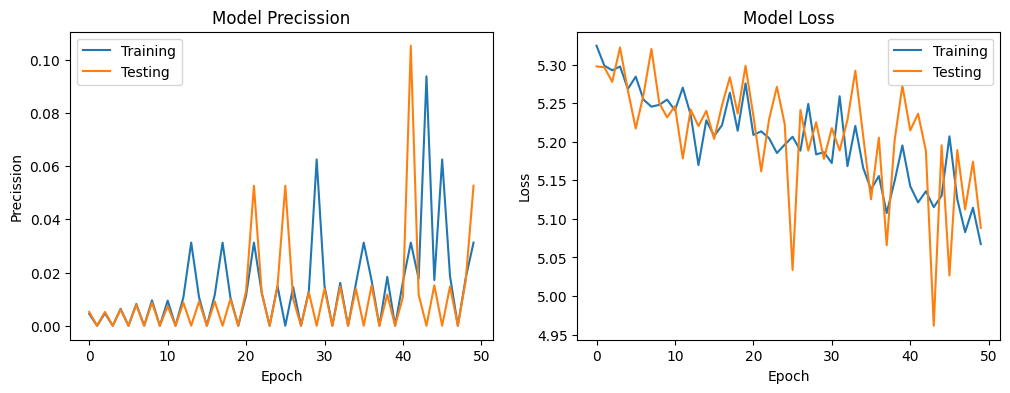

In [ ]:
import matplotlib.pyplot as plt

# Graphic showing the precission and loss during the training
plt.figure(figsize=(12, 4))

# Precission
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Testing')
plt.title('Model Precission')
plt.xlabel('Epoch')
plt.ylabel('Precission')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Testing')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.save('bird_species_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
loaded_model = load_model('bird_species_model.h5')

# Realizar predicciones (ejemplo para una imagen del directorio de validación)
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/content/cub-200-2011/images/test_image.jpg'  # Ajusta la ruta a la imagen que quieres predecir
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Añade una dimensión para representar el lote de tamaño 1

prediction = loaded_model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)
print(f'La clase predicha es: {predicted_class}')